## Baseline

[Kaggle competition](https://www.kaggle.com/c/fdl21-fdl-dsba/overview)

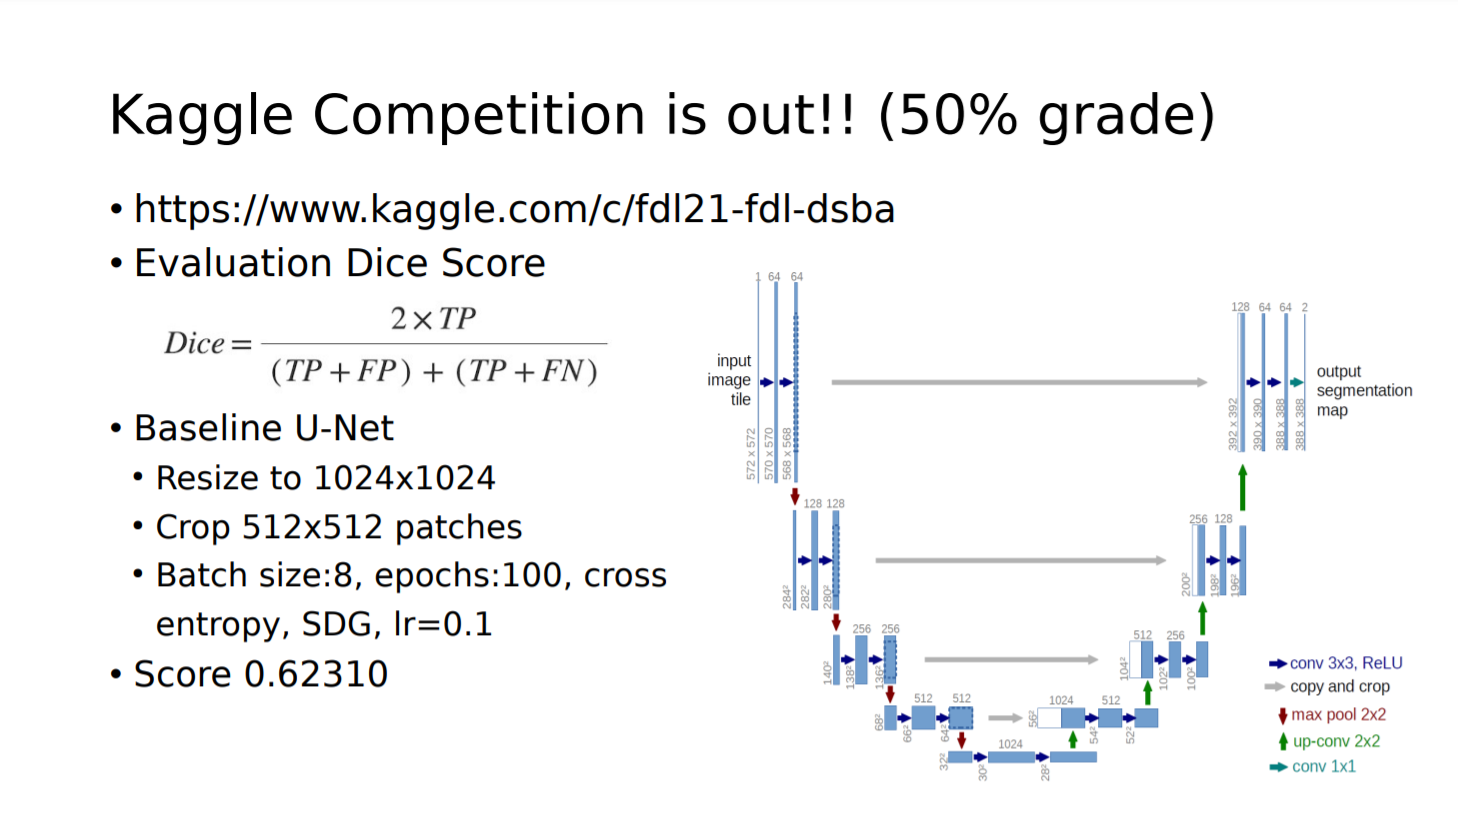

Note on labels:

Class #24 (boat) is only represented in 4 of the training images: 6970, 7256, 6693 and 6695.

## Imports

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import cv2
from PIL import Image
from skimage.io import imread, imsave

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, transforms
from tqdm import tqdm

!pip install torchnet
import torchnet as tnt

!pip install -U segmentation-models-pytorch
import segmentation_models_pytorch as smp

## Kaggle Connection

In [2]:
!pip install kaggle
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions files -c fdl21-fdl-dsba
# !kaggle competitions download -c fdl21-fdl-dsba -p data

mv: cannot stat 'kaggle.json': No such file or directory
name                                  size  creationDate         
-----------------------------------  -----  -------------------  
test_images/test_images/6463.jpg       4MB  2021-11-20 01:02:08  
test_images/test_images/6413.jpg       4MB  2021-11-20 01:02:08  
test_images/test_images/6466.jpg       4MB  2021-11-20 01:02:08  
test_images/test_images/6450.jpg       4MB  2021-11-20 01:02:08  
test_images/test_images/10566.jpg      4MB  2021-11-20 01:02:08  
test_images/test_images/10184.jpg      5MB  2021-11-20 01:02:08  
test_images/test_images/10808.jpg      4MB  2021-11-20 01:02:08  
test_images/test_images/10171.jpg      5MB  2021-11-20 01:02:08  
test_images/test_images/6459.jpg       4MB  2021-11-20 01:02:08  
test_images/test_images/6427.jpg       5MB  2021-11-20 01:02:08  
test_images/test_images/10812.jpg      4MB  2021-11-20 01:02:08  
test_images/test_images/6455.jpg       4MB  2021-11-20 01:02:08  
test_images/test_im

## Google Drive Data Access

In [3]:
import os
import glob
from google.colab import drive

## connect your drive with the notebook
drive = drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
project_folder = "drive/My Drive/FDL Project/"

I put the dataset into a folder named 'FDL Project' in my drive.
This folder contains three folders: 'train_images', 'test_images' and 'train_masks' containing the data.
To set-up the same environment, you'll need to download the Kaggle data ([Kaggle data here](https://www.kaggle.com/c/fdl21-fdl-dsba/data) at the bottom of the page), unzip the file and upload the folders 'train_images/train_images', 'test_images/test_images' and 'train_masks/train_masks' into the 'FDL Project' in your drive.

After that, just create an empty folder named 'models' in the 'FDL Project' folder in your drive. We'll save our models there.

## Data loading

### Dataset Class

In [5]:

class Dataset(data.Dataset):
    
    N_CLASSES = 25

    def __init__(
            self, inputs, targets, 
            classes=None,
            ignored_classes=None,
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_fps = inputs
        self.masks_fps = targets
        if classes is not None:
          self.classes = classes
        else:
          self.classes = np.arange(self.N_CLASSES)
        self.ignored_classes = ignored_classes
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.resize(image, (512, 512))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask, (512, 512))
        
        # extract certain classes from mask (e.g. cars)
        masks = []
        if self.ignored_classes is not None:
            masks += [np.sum([(mask == v) for v in self.ignored_classes], axis=0)]
        masks += [(mask == v) for v in self.classes]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            image = self.preprocessing(image)
            image = image.transpose(2, 0, 1).astype('float32')
            mask = mask.transpose(2, 0, 1).astype('float32')
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

### Dataset Generation

In [6]:
train_images = list(glob.glob(os.path.join(project_folder + "train_images/*.jpg")))
train_masks = list(glob.glob(os.path.join(project_folder + "train_masks/*.png")))
train_images.sort()
train_masks.sort()

split_train_test = 0.8
n_images = len(train_images)
n_train = int(n_images * split_train_test)
n_val = n_images - n_train

indices = np.arange(n_images)
np.random.shuffle(indices)
train_indices = indices[:n_train]
val_indices = indices[n_train:]

val_images = [train_images[i] for i in val_indices]
val_masks = [train_masks[i] for i in val_indices]
train_images = [train_images[i] for i in train_indices]
train_masks = [train_masks[i] for i in train_indices]

## Training

In [7]:
save_folder = project_folder + "models"

### Training utility functions

In [8]:
##function which saves the overall accuracy and average loss at the end of each epoch,
##both for the training and the validation set
def write_results(save_folder, epoch, train_iou, val_iou, train_loss, val_loss):
    ff=open('./{}/progress.txt'.format(save_folder),'a')
    ff.write(' E: ')
    ff.write(str(epoch))
    ff.write('         ')
    ff.write(' TRAIN_IoU: ')
    ff.write(str('%.3f' % train_iou))
    ff.write(' VAL_IoU: ')
    ff.write(str('%.3f' % val_iou))
    ff.write('         ')
    ff.write(' TRAIN_LOSS: ')
    ff.write(str('%.3f' % train_loss))
    ff.write(' VAL_LOSS: ')
    ff.write(str('%.3f' % val_loss))
    ff.write('\n')

#function that creates the train-val loss graph
#variables 'train_loss' and 'val_loss' are losts containing the average losses for all the epochs
def save_graph(train_loss, val_loss, nb_epochs, save_folder):
    plt.plot(list(range(nb_epochs+1))[1:], train_loss)
    plt.plot(list(range(nb_epochs+1))[1:], val_loss)
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('{}/chart.png'.format(save_folder))

def save_confusion_matrix(conf_mat, epoch, save_folder, n_classes):
    plt.ioff()
    classes = [str(i) for i in range(n_classes)]
    df_cfm = pd.DataFrame(conf_mat, index = classes, columns = classes)
    plt.figure(figsize = (20, 14))
    cfm_plot = sn.heatmap(df_cfm, annot=True)
    cfm_plot.figure.savefig('{}/cm_{}.png'.format(save_folder, epoch))

In [9]:
def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

### Training process

In [10]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

classes = np.arange(7, 25)
n_classes = len(classes)
ignored_classes = np.arange(7)
if ignored_classes is not None:
    n_classes += 1

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=n_classes, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [11]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        albu.RandomCrop(height=512, width=512, always_apply=True),
    ]
    return albu.Compose(train_transform)

In [12]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-3),
])

In [13]:

train_dataset = Dataset(
    inputs=train_images, targets=train_masks,
    classes = classes, ignored_classes = ignored_classes,
    preprocessing=preprocessing_fn
)

valid_dataset = Dataset(
    inputs=val_images, targets=val_masks, 
    classes = classes, ignored_classes = ignored_classes,
    preprocessing=preprocessing_fn
)

train_dataloader = data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_dataloader = data.DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

In [14]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [15]:
max_score = 0

total_train_losses = []
total_val_losses = []

epochs = 200

for epoch in range(1,epochs+1):
    
    print('\nEpoch: {}'.format(epoch))
    train_logs = train_epoch.run(train_dataloader)
    val_logs = valid_epoch.run(val_dataloader)

    if len(val_dataloader) > 0:
        if max_score < val_logs['iou_score']:
            max_score = val_logs['iou_score']
            torch.save(model, save_folder + '_2/best_model.pth')
            print('Model saved!')

        total_train_losses.append(train_logs['dice_loss'])
        total_val_losses.append(val_logs['dice_loss'])

        write_results(save_folder + "_2", epoch, 
                      train_logs['iou_score'], val_logs['iou_score'], 
                      train_logs['dice_loss'], val_logs['dice_loss'])
    else:
        # torch.save(model, save_folder + '_2/model_{}.pt'.format(i))
        torch.save(model, save_folder + '_2/best_model.pth')
        print('Model saved!')
        
    if epoch == 24:
        optimizer.param_groups[0]['lr'] = 1e-3
        print('Decrease decoder learning rate to 1e-3!')
    elif epoch == 99:
        optimizer.param_groups[0]['lr'] = 1e-4
        print('Decrease decoder learning rate to 1e-4!')

save_graph(total_train_losses, total_val_losses, epochs, save_folder + "_2")



Epoch: 1
valid: 100%|██████████| 53/53 [00:15<00:00,  3.37it/s, dice_loss - 0.2933, iou_score - 0.6602, accuracy - 0.9779]
Model saved!

Epoch: 2
valid: 100%|██████████| 53/53 [00:15<00:00,  3.34it/s, dice_loss - 0.2524, iou_score - 0.627, accuracy - 0.9744]

Epoch: 3
valid: 100%|██████████| 53/53 [00:16<00:00,  3.30it/s, dice_loss - 0.2105, iou_score - 0.6751, accuracy - 0.9784]
Model saved!

Epoch: 4
valid: 100%|██████████| 53/53 [00:15<00:00,  3.35it/s, dice_loss - 0.1878, iou_score - 0.7015, accuracy - 0.9805]
Model saved!

Epoch: 5
valid: 100%|██████████| 53/53 [00:15<00:00,  3.33it/s, dice_loss - 0.1931, iou_score - 0.6958, accuracy - 0.9801]

Epoch: 6
valid: 100%|██████████| 53/53 [00:16<00:00,  3.26it/s, dice_loss - 0.1875, iou_score - 0.7071, accuracy - 0.9805]
Model saved!

Epoch: 7
valid: 100%|██████████| 53/53 [00:15<00:00,  3.32it/s, dice_loss - 0.1812, iou_score - 0.713, accuracy - 0.9811]
Model saved!

Epoch: 8
valid: 100%|██████████| 53/53 [00:15<00:00,  3.33it/s, dice

KeyboardInterrupt: ignored

## Test set prediction

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'  # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

model = torch.load(save_folder + '_2/best_model.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
model.to(device)
model.eval()
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
0

In [ ]:

test_images = list(glob.glob(os.path.join(project_folder + "test_images/*.jpg")))
test_images.sort()

to_tensor_transform = transforms.PILToTensor()

pred_distribution = np.zeros(25)

for img_path in test_images:

    orig_image = cv2.imread(img_path)
    h, w, d = orig_image.shape
    image = cv2.resize(orig_image, (512, 512))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image = preprocessing_fn(image)
    image = image.transpose(2, 0, 1).astype('float32')

    image = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    output = model.predict(image)

    pred = output.argmax(1).unsqueeze(1)

    out_transform = transforms.Resize((h, w))
    pred = out_transform(pred).squeeze()
    
    pred_distribution += [len(np.where(pred.flatten().cpu().numpy() == i)[0]) for i in range(25)]

    pred_path = project_folder + "test_preds/" + img_path.split("/")[-1][:-4] + ".png"

    imsave(pred_path, pred.data.type(torch.uint8).cpu().numpy())

    break

for i, count in enumerate(pred_distribution):
    print("Label {} has been predicted {:.0f} times".format(i, count))

plot([orig_image, 
      pred.squeeze().cpu()])


In [ ]:
!python "drive/My Drive/FDL Project/prepare_submission.py"

In [ ]:
!kaggle competitions submit -c fdl21-fdl-dsba -f "drive/My Drive/FDL Project/submission_file.csv" -m ""

## Model combination

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'  # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

main_model = torch.load(save_folder + '_2/best_model_main.pth')
main_model.to(device)
main_model.eval()

second_model = torch.load(save_folder + '_2/best_model_second.pth')
second_model.to(device)
second_model.eval()
0

In [ ]:

def combine_predictions(pred_main, pred_second, offset = 6):
    pred = pred_main
    for i in range(17, np.max(pred_second) + 1):
        pred[np.where(pred_second == i)] = offset + i
    return pred


In [ ]:

test_images = list(glob.glob(os.path.join(project_folder + "test_images/*.jpg")))
test_images.sort()

to_tensor_transform = transforms.PILToTensor()

pred_distribution = np.zeros(25)

for img_path in test_images:

    orig_image = cv2.imread(img_path)
    h, w, d = orig_image.shape
    image = cv2.resize(orig_image, (512, 512))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image = preprocessing_fn(image)
    image = image.transpose(2, 0, 1).astype('float32')

    image = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    out_transform = transforms.Resize((h, w))

    output_main = main_model.predict(image)
    pred_main = output_main.argmax(1).unsqueeze(1)
    pred_main = out_transform(pred_main).squeeze()

    output_second = second_model.predict(image)
    pred_second = output_second.argmax(1).unsqueeze(1)
    pred_second = out_transform(pred_second).squeeze()

    pred = combine_predictions(pred_main.data.type(torch.uint8).cpu().numpy(), 
                               pred_second.data.type(torch.uint8).cpu().numpy(),
                               offset = 6)

    pred_distribution += [len(np.where(pred == i)[0]) for i in range(25)]

    pred_path = project_folder + "test_preds/" + img_path.split("/")[-1][:-4] + ".png"

    imsave(pred_path, pred)

    if np.max(pred) > 22:
        plot([orig_image, pred])
        break

for i, count in enumerate(pred_distribution):
    print("Label {} has been predicted {:.0f} times".format(i, count))

plot([orig_image, pred])
